In [1]:
# Cell 1
import os
import math
import time
import pickle
import random

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
# Cell 2
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


C:\Users\333\PycharmProjects\predicting-investment-activity\.venv\Lib\site-packages\torch\cuda\__init__.py:182: UserWarning: cudaGetDeviceCount() returned cudaErrorNotSupported, likely using older driver or on CPU machine (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10\cuda\CUDAFunctions.cpp:88.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
# Cell 3
IDX_TO_NAME_PATH = "../../Data/idx_to_name.pkl"

with open(IDX_TO_NAME_PATH, "rb") as f:
    idx_to_name_all = pickle.load(f)

In [4]:
# Cell 4
CKPT_PATH = "best_ar_transformer.pt"
SCALER_X_PATH = "transformer_scaler_x.pkl"
SCALER_Y_PATH = "transformer_scaler_y.pkl"
DATA_PATH = "../../Data/russian_investment.csv"

SEQ_LEN = 8
HORIZON = 3
BATCH_SIZE = 8
FINE_TUNE_EPOCHS = 30
LR = 3e-4

In [5]:
# Cell 5
with open(SCALER_X_PATH, "rb") as f:
    scaler_x = pickle.load(f)

with open(SCALER_Y_PATH, "rb") as f:
    scaler_y = pickle.load(f)

ckpt = torch.load(CKPT_PATH, map_location="cpu")
cfg = ckpt["cfg"]

In [6]:
# Cell 6
class PositionalEncodingFlexible(nn.Module):
    def __init__(self, d_model, max_len=500, mode='sin'):
        super().__init__()
        self.mode = mode
        self.d_model = d_model
        if mode == 'sin':
            pe = torch.zeros(max_len, d_model)
            position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
            div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
            pe[:, 0::2] = torch.sin(position * div_term)
            pe[:, 1::2] = torch.cos(position * div_term)
            self.register_buffer('pe', pe.unsqueeze(0))
        elif mode == 'learned':
            self.pe = nn.Parameter(torch.randn(1, max_len, d_model) * 0.02)
        else:
            raise ValueError("pos_type must be 'sin' or 'learned'")

    def forward(self, x):
        seq_len = x.size(1)

        if self.mode == 'sin' and seq_len > self.pe.size(1):
            old_len = self.pe.size(1)
            extra_len = seq_len - old_len

            position = torch.arange(old_len, seq_len, dtype=torch.float32, device=x.device).unsqueeze(1)
            div_term = torch.exp(torch.arange(0, self.d_model, 2, device=x.device).float() * (-math.log(10000.0) / self.d_model))
            new_pe = torch.zeros(extra_len, self.d_model, device=x.device)
            new_pe[:, 0::2] = torch.sin(position * div_term)
            new_pe[:, 1::2] = torch.cos(position * div_term)

            self.pe = torch.cat([self.pe, new_pe.unsqueeze(0)], dim=1)

        return x + self.pe[:, :seq_len, :].to(x.device) if self.mode == 'sin' else x + self.pe[:, :seq_len, :]

class ARTransformerForecaster(nn.Module):
    def __init__(self,
                 n_features,
                 d_model=128,
                 nhead=8,
                 num_layers=2,
                 dim_feedforward=256,
                 dropout=0.1,
                 horizon=None,
                 pos_type='sin',
                 input_dropout=0.0,
                 input_noise_std=0.0,
                 pool_type='last_mean',
                 region_emb_size=0,
                 norm_ctx=True,
                ):
        super().__init__()
        self.horizon = horizon
        self.n_features = n_features
        self.d_model = d_model
        self.pool_type = pool_type
        self.input_noise_std = float(input_noise_std) if input_noise_std is not None else 0.0
        self.region_emb_size = int(region_emb_size)

        if self.region_emb_size > 0:
            self.region_emb = nn.Embedding(100, self.region_emb_size)
            proj_in_features = n_features + self.region_emb_size
        else:
            self.region_emb = None
            proj_in_features = n_features

        self.input_proj = nn.Linear(proj_in_features, d_model)
        self.input_dropout = nn.Dropout(input_dropout) if input_dropout and input_dropout > 0.0 else None

        self.pos_enc = PositionalEncodingFlexible(d_model, max_len=8, mode=pos_type)

        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first=True)
        self.transformer_enc = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        if pool_type == 'attn':
            self.pool_query = nn.Parameter(torch.randn(d_model))
        ctx_dim = d_model * 2

        self.norm_ctx = nn.LayerNorm(ctx_dim) if norm_ctx else None

        self.start_proj = nn.Linear(ctx_dim, 1)
        
        self.step_emb_dim = d_model // 4 
        self.step_emb = nn.Embedding(horizon, self.step_emb_dim) 

        self.dec_fc1 = nn.Linear(ctx_dim + 1 + self.step_emb_dim, dim_feedforward)
        self.dec_act = nn.GELU()
        self.dec_ln = nn.LayerNorm(dim_feedforward)
        self.dec_fc2 = nn.Linear(dim_feedforward, 1)
        self.dec_dropout = nn.Dropout(dropout) if dropout and dropout > 0 else None

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Embedding):
                nn.init.normal_(m.weight, mean=0.0, std=0.02)

    def _pool(self, enc_out):
        if self.pool_type == 'last_mean':
            return torch.cat([enc_out[:, -1, :], enc_out.mean(dim=1)], dim=1)
        elif self.pool_type == 'attn':
            q = self.pool_query.unsqueeze(0).unsqueeze(2)
            scores = torch.matmul(enc_out, q).squeeze(2)
            w = torch.softmax(scores, dim=1).unsqueeze(2)
            ctx_att = torch.sum(enc_out * w, dim=1)
            return torch.cat([enc_out[:, -1, :], ctx_att], dim=1)
        else:
            raise ValueError("Unknown pool_type")

    def forward(self, x, region=None, y=None, y_last=None, teacher_forcing=False):
        B = x.size(0)
        if self.region_emb is not None:
            if region is None:
                reg_emb = torch.zeros(B, self.region_emb_size, device=x.device)
            else:
                if isinstance(region, torch.Tensor):
                    reg_idx = region.to(dtype=torch.long, device=x.device)
                else:
                    reg_idx = torch.tensor(region, dtype=torch.long, device=x.device)
                reg_emb = self.region_emb(reg_idx)
            reg_expand = reg_emb.unsqueeze(1).expand(-1, x.size(1), -1)
            x = torch.cat([x, reg_expand], dim=2)

        if self.input_noise_std and self.training and self.input_noise_std > 0.0:
            noise = torch.randn_like(x) * float(self.input_noise_std)
            x = x + noise

        x = self.input_proj(x)
        if self.input_dropout is not None and self.training:
            x = self.input_dropout(x)
        x = self.pos_enc(x)
        enc = self.transformer_enc(x)

        ctx = self._pool(enc)
        if self.norm_ctx is not None:
            ctx = self.norm_ctx(ctx)

        preds = []
        
        if y_last is None:
            prev = self.start_proj(ctx).squeeze(1)
        else:
            prev = y_last

        for t in range(self.horizon):
            step_emb = self.step_emb(
                torch.full((B,), t, device=ctx.device, dtype=torch.long)
            )
            inp = torch.cat([ctx, prev.unsqueeze(1), step_emb], dim=1)
            h = self.dec_fc1(inp)
            h = self.dec_act(h)
            if self.dec_dropout is not None and self.training:
                h = self.dec_dropout(h)
            h = self.dec_ln(h)
            out = self.dec_fc2(h).squeeze(1)
            preds.append(out.unsqueeze(1))
            if teacher_forcing and (y is not None):
                prev = y[:, t] if t < y.size(1) else out
            else:
                prev = out
        preds = torch.cat(preds, dim=1)
        return preds

In [7]:
# Cell 7
def create_model_from_cfg(cfg, state_dict=None, device=device, n_features=None, horizon=None):
    d_model = cfg['d_model']
    nhead = cfg.get('nhead', 1)
    if d_model % nhead != 0:
        possible = [h for h in [1, 2, 4, 8, 16] if h <= d_model and d_model % h == 0]
        nhead = possible[-1] if len(possible) > 0 else 1

    model = ARTransformerForecaster(
        n_features=n_features,
        d_model=d_model,
        nhead=nhead,
        num_layers=cfg['num_layers'],
        dim_feedforward=cfg['dim_feedforward'],
        dropout=cfg['dropout'],
        horizon=horizon,
        pos_type=cfg.get('pos_type', 'sin'),
        input_dropout=cfg.get('input_dropout', 0.0),
        input_noise_std=cfg.get('input_noise_std', 0.0),
        pool_type=cfg.get('pool_type', 'last_mean'),
        region_emb_size=cfg.get('region_emb_size', 0),
        norm_ctx=cfg.get('norm_ctx', True)
    ).to(device)

    if state_dict is not None:
        model.load_state_dict(state_dict)
    return model

In [8]:
# Cell 8
model = create_model_from_cfg(
    cfg,
    state_dict=ckpt["state_dict"],
    device=device,
    n_features=61,
    horizon=HORIZON
)

model.train()

Model loaded. Params: 62194


In [9]:
# Cell 9
model

ARTransformerForecaster(
  (region_emb): Embedding(100, 32)
  (input_proj): Linear(in_features=93, out_features=64, bias=True)
  (input_dropout): Dropout(p=0.11574001055385535, inplace=False)
  (pos_enc): PositionalEncodingFlexible()
  (transformer_enc): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0.06253384149665461, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.06253384149665461, inplace=False)
        (dropout2): Dropout(p=0.06253384149665461, inplace=False)
      )
    )
  )
  (norm_ctx): Lay

In [10]:
# Cell 10
for name, param in model.named_parameters():
    if "input_proj" in name or "pos_enc" in name or "region_emb" in name:
        param.requires_grad = False
    else:
        param.requires_grad = True

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")

Total parameters: 62194
Trainable parameters: 52978


In [11]:
# Cell 11
class FineTune2024Dataset(Dataset):
    def __init__(self, df, features, target_col, scaler_x, scaler_y):
        self.records = []

        for region in df['region_encoded'].unique():
            grp = df[df['region_encoded'] == region].sort_values('year')

            years = grp['year'].values
            X = grp[features].values.astype(np.float32)
            y = grp[target_col].values.astype(np.float32)

            for i in range(len(grp) - SEQ_LEN):
                x_years = years[i:i+SEQ_LEN]

                if list(x_years) == [2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]:
                    self.records.append({
                        "X": X[i:i+SEQ_LEN],
                        "Y": y[i+SEQ_LEN:i+SEQ_LEN+1],
                        "y_last": y[i+SEQ_LEN-1],
                        "region": int(region)
                    })

        self.scaler_x = scaler_x
        self.scaler_y = scaler_y

    def __len__(self):
        return len(self.records)

    def __getitem__(self, idx):
        r = self.records[idx]

        Xs = self.scaler_x.transform(
            r["X"].reshape(-1, r["X"].shape[1])
        ).reshape(r["X"].shape)

        Ys = self.scaler_y.transform(
            r["Y"].reshape(-1, 1)
        ).reshape(-1)

        y_last_s = self.scaler_y.transform(
            np.array([[r["y_last"]]])
        ).reshape(())

        return {
            "X": torch.tensor(Xs, dtype=torch.float32),
            "Y": torch.tensor(Ys, dtype=torch.float32),
            "y_last": torch.tensor(y_last_s, dtype=torch.float32),
            "region": torch.tensor(r["region"], dtype=torch.long),
        }

In [12]:
# Cell 12
def horizon1_loss(pred, target, loss_type="huber", huber_delta=1.0):
    pred_2024 = pred[:, 0]
    target_2024 = target[:, 0]

    if loss_type == "mae":
        return torch.mean(torch.abs(pred_2024 - target_2024))
    elif loss_type == "mse":
        return torch.mean((pred_2024 - target_2024) ** 2)
    elif loss_type == "huber":
        err = pred_2024 - target_2024
        abs_err = torch.abs(err)
        quad = 0.5 * err ** 2
        lin = huber_delta * (abs_err - 0.5 * huber_delta)
        return torch.mean(torch.where(abs_err <= huber_delta, quad, lin))

In [13]:
# Cell 13
optimizer = torch.optim.AdamW(model.parameters([
    {"params": model.transformer_enc.parameters(), "lr": 1e-5},
    {"params": model.dec_fc1.parameters(), "lr": 1e-5},
    {"params": model.dec_fc2.parameters(), "lr": 1e-5},
]), lr=LR, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=FINE_TUNE_EPOCHS, eta_min=1e-5)

In [14]:
# Cell 14
def train_epoch(model, loader):
    model.train()
    total_loss = 0.0

    for batch in loader:
        X = batch["X"].to(device)
        Y = batch["Y"].to(device)
        y_last = batch["y_last"].to(device)
        region = batch["region"].to(device)

        optimizer.zero_grad()

        preds = model(
            X,
            region=region,
            y=None,
            y_last=y_last,
            teacher_forcing=False
        )

        loss = horizon1_loss(preds, Y, loss_type="huber", huber_delta=1.0)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item() * X.size(0)

    return total_loss / len(loader.dataset)

In [15]:
# Cell 15
df = pd.read_csv(DATA_PATH, sep=';')
exclude_cols = [
    "year", 
    "region", 
    "district", 
    'delta_target', 
    'delta_target_percent', 
    'log_target_next_year', 
    'target_next_year',  
    'capital_investments_million_rub',
    'gross_regional_product_lag_1',
    'gross_regional_product_lag_2',
    'population_lag_1',
    'population_lag_2',
    'unemployment_rate_15_72_years_percent_lag_1',
    'unemployment_rate_15_72_years_percent_lag_2',
    'average_salary_rub_lag_1',
    'average_salary_rub_lag_2',
    'retail_trade_turnover_million_rub_lag_1',
    'retail_trade_turnover_million_rub_lag_2',
    'total_money_income_million_rub_lag_1',
    'total_money_income_million_rub_lag_2',
    'internal_rnd_costs_million_rub_lag_1',
    'internal_rnd_costs_million_rub_lag_2',
    'accounts_payable_total_lag_1',
    'accounts_payable_total_lag_2',
    'number_of_crimes_registered_total'
]
features = [c for c in df.columns if c not in exclude_cols]
TARGET_COL = "log_capital_investments_million_rub"

dataset = FineTune2024Dataset(
    df,
    features,
    TARGET_COL,
    scaler_x,
    scaler_y
)

loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [16]:
# Cell 16
loss_history = []
best_loss = float("inf")

for epoch in range(1, FINE_TUNE_EPOCHS + 1):
    loss = train_epoch(model, loader)
    
    loss_history.append(loss)
    
    # scheduler.step() # OPTIONAL
    
    if epoch == 1 or epoch % 5 == 0:
        print(f"[{epoch}/{FINE_TUNE_EPOCHS}] loss_2024 = {loss:.6f}")

    if loss < best_loss:
        best_loss = loss
        torch.save(
            {
                "state_dict": model.state_dict(),
                "cfg": cfg,
                "fine_tuned_on": "2020-2023 -> 2024 only",
                "best_loss": best_loss,
                "loss_history": loss_history,
                "timestamp": time.time()
            },
            "best_ar_transformer_finetuned_2024.pt"
        )
        print(f"Model saved at epoch {epoch} with best_loss = {best_loss:.6f}")

[1/30] loss_2024 = 0.029650
Model saved at epoch 1 with best_loss = 0.029650
Model saved at epoch 2 with best_loss = 0.014852
Model saved at epoch 3 with best_loss = 0.013180
[5/30] loss_2024 = 0.017951
Model saved at epoch 7 with best_loss = 0.011493
[10/30] loss_2024 = 0.016153
[15/30] loss_2024 = 0.012970
Model saved at epoch 17 with best_loss = 0.008168
[20/30] loss_2024 = 0.009813
[25/30] loss_2024 = 0.009091
Model saved at epoch 26 with best_loss = 0.007730
[30/30] loss_2024 = 0.006893
Model saved at epoch 30 with best_loss = 0.006893


In [17]:
# Cell 17
history_data = {
    "loss_history": loss_history,
    "best_loss": best_loss,
    "epochs": FINE_TUNE_EPOCHS,
    "timestamp": time.time()
}

torch.save(history_data, "training_loss_history.pt")
print(f"Training history saved. Best loss: {best_loss:.6f}")

Training history saved. Best loss: 0.006893


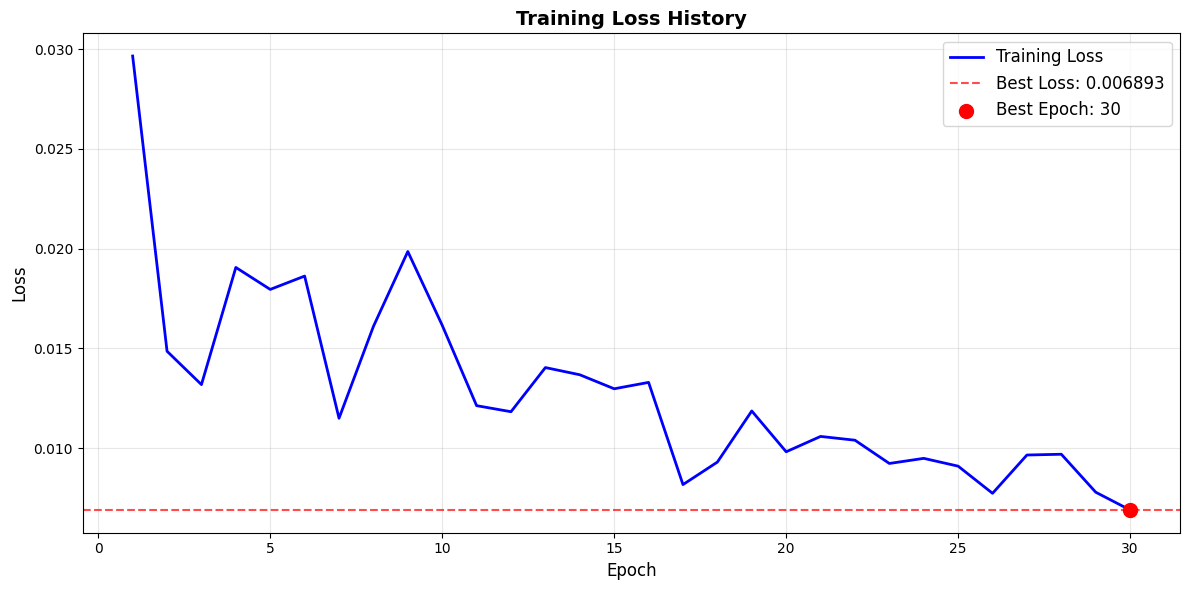

In [18]:
# Cell 18
plt.figure(figsize=(12, 6))

plt.subplot(1, 1, 1)
plt.plot(range(1, len(loss_history) + 1), loss_history, 'b-', linewidth=2, label='Training Loss')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss History', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

plt.axhline(y=best_loss, color='r', linestyle='--', alpha=0.7, label=f'Best Loss: {best_loss:.6f}')

best_epoch = np.argmin(loss_history) + 1
plt.scatter(best_epoch, best_loss, color='red', s=100, zorder=5, 
           label=f'Best Epoch: {best_epoch}')

plt.legend(fontsize=12)
plt.tight_layout()

plt.savefig('training_loss_plot.png', dpi=150, bbox_inches='tight')
plt.show()


TRAINING STATISTICS
Total epochs: 30
Best loss: 0.006893 (epoch 30)
Final loss: 0.006893
Improvement from first to last: 0.022756
Average loss: 0.012816


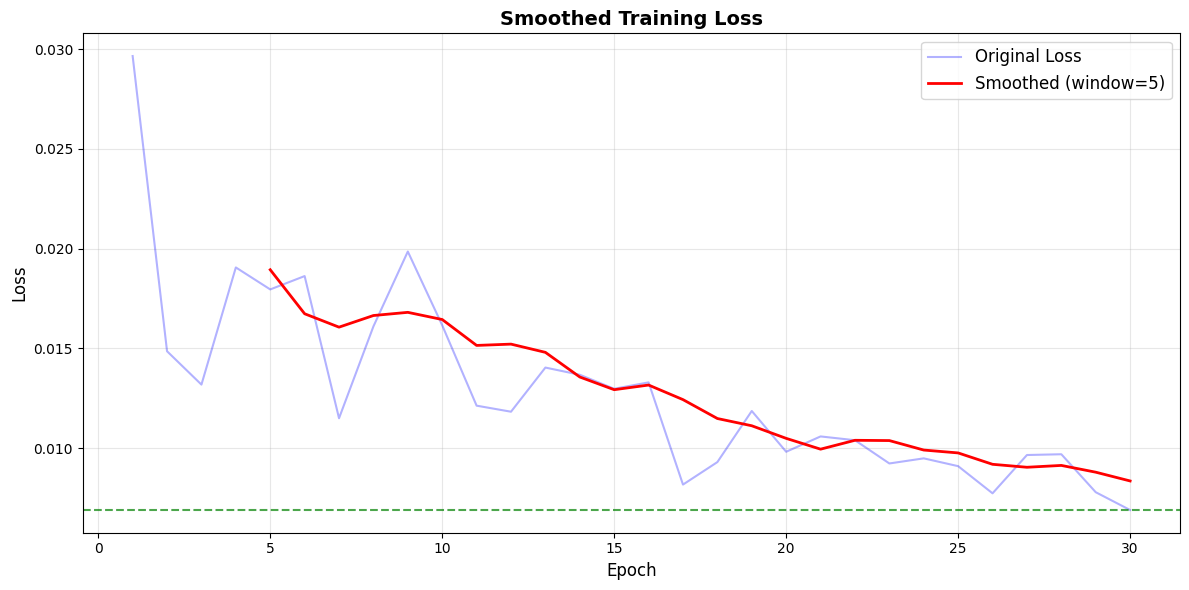

In [19]:
# Cell 19
print("\n" + "="*50)
print("TRAINING STATISTICS")
print("="*50)
print(f"Total epochs: {len(loss_history)}")
print(f"Best loss: {best_loss:.6f} (epoch {best_epoch})")
print(f"Final loss: {loss_history[-1]:.6f}")
print(f"Improvement from first to last: {loss_history[0] - loss_history[-1]:.6f}")
print(f"Average loss: {np.mean(loss_history):.6f}")
print("="*50)

if len(loss_history) > 10:
    plt.figure(figsize=(12, 6))
    
    plt.plot(range(1, len(loss_history) + 1), loss_history, 'b-', alpha=0.3, label='Original Loss')
    
    window_size = max(5, len(loss_history) // 10)
    if window_size < len(loss_history):
        smoothed_loss = np.convolve(loss_history, np.ones(window_size)/window_size, mode='valid')
        plt.plot(range(window_size, len(loss_history) + 1), smoothed_loss, 
                'r-', linewidth=2, label=f'Smoothed (window={window_size})')
    
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Smoothed Training Loss', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.axhline(y=best_loss, color='g', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('smoothed_training_loss_plot.png', dpi=150, bbox_inches='tight')
    plt.show()

In [20]:
# Cell 20
ckpt = torch.load("best_ar_transformer_finetuned_2024.pt", map_location="cpu")
cfg = ckpt["cfg"]

model = create_model_from_cfg(
    cfg,
    state_dict=ckpt["state_dict"],
    device=device,
    n_features=61,
    horizon=HORIZON
)

In [21]:
# Cell 21
model.eval()

records_eval = []

with torch.no_grad():
    for batch in DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False):
        X = batch["X"].to(device)
        Y = batch["Y"].to(device)
        y_last = batch["y_last"].to(device)
        region = batch["region"].to(device)

        preds = model(
            X,
            region=region,
            y=None,
            y_last=y_last,
            teacher_forcing=False
        )

        pred_2024_scaled = preds[:, 0].cpu().numpy()
        true_2024_scaled = Y[:, 0].cpu().numpy()

        pred_2024_log = scaler_y.inverse_transform(
            pred_2024_scaled.reshape(-1, 1)
        ).reshape(-1)

        true_2024_log = scaler_y.inverse_transform(
            true_2024_scaled.reshape(-1, 1)
        ).reshape(-1)

        pred_2024_real = np.expm1(pred_2024_log)
        true_2024_real = np.expm1(true_2024_log)

        for i in range(len(region)):
            records_eval.append({
                "region": idx_to_name_all['region'][int(region[i].item())],
                "pred_2024_real": pred_2024_real[i],
                "true_2024_real": true_2024_real[i],
            })

In [22]:
# Cell 22
df_eval = pd.DataFrame(records_eval)

df_eval["abs_err_2024"] = np.abs(
    df_eval["pred_2024_real"] - df_eval["true_2024_real"]
)

df_region_mae = (
    df_eval
    .groupby("region")["abs_err_2024"]
    .mean()
    .reset_index()
    .rename(columns={"abs_err_2024": "MAE_2024"})
)

In [23]:
# Cell 23
mean_mae_2024 = df_region_mae["MAE_2024"].mean()

print(f"Regions evaluated: {len(df_region_mae)}")
print(f"Mean MAE for 2024 (averaged across regions): {mean_mae_2024:.4f}")

Regions evaluated: 87
Mean MAE for 2024 (averaged across regions): 31066.4219


In [24]:
# Cell 24
print("Regions by MAE (2024):")
print(
    df_region_mae
    .sort_values("MAE_2024", ascending=False)
    .to_string(index=False)
)

Regions by MAE (2024):
                                      region      MAE_2024
                       Ленинградская область 250715.687500
                           Тюменская область 187712.750000
                        Республика Татарстан 156090.625000
                           Иркутская область 135275.500000
                                    г.Москва 130305.500000
                           г.Санкт-Петербург 128302.750000
                            Хабаровский край 117564.281250
                         Кемеровская область 114607.906250
                           Самарская область 104578.937500
             Ямало-Ненецкий автономный округ 100503.125000
                           Красноярский край  65179.500000
                       Новосибирская область  62805.812500
                          Московская область  59332.375000
                         Ставропольский край  54702.312500
                             Приморский край  49623.593750
                          Краснод

In [25]:
# Cell 25
model.eval()

records_eval_full = []

with torch.no_grad():
    for batch in DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False):
        X = batch["X"].to(device)
        Y = batch["Y"].to(device)
        y_last = batch["y_last"].to(device)
        region = batch["region"].to(device)

        preds = model(
            X,
            region=region,
            y=None,
            y_last=y_last,
            teacher_forcing=False
        )
        pred_scaled = preds.cpu().numpy()
        true_scaled = Y.cpu().numpy()

        n_years = preds.shape[1]
        
        for i in range(len(region)):
            for year_idx in range(n_years):
                year = 2024 + year_idx
                records_eval_full.append({
                    "region": idx_to_name_all['region'][int(region[i].item())],
                    "year": year,
                    "pred_real": np.expm1(scaler_y.inverse_transform(
                        pred_scaled[i, year_idx].reshape(-1, 1)
                    ).item()),
                    "true_real": np.expm1(scaler_y.inverse_transform(
                        true_scaled[i, year_idx].reshape(-1, 1)
                    ).item()) if year_idx < true_scaled.shape[1] else None,
                })

In [26]:
# Cell 26
df_eval = pd.DataFrame(records_eval_full)
df_eval.to_csv('preds.csv', index=False)